<a href="https://colab.research.google.com/github/ssyeon2/Flight-Delay-Prediction/blob/main/SEN/%5BSEN%5DEDA_LogisticRegression%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import pandas as pd
import numpy as np
import random
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# csv to parquet
메모리에 효율적인 데이터 유형을 사용하여 용량을 줄이고 빠른 작업이 가능합니다

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [ ]:
csv_to_parquet('/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/open/train.csv', 'train')
csv_to_parquet('/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/open/test.csv', 'test')

train Done.
test Done.


# Data Load

**Columns**
- ID : 샘플 고유 id
항공편 운항 관련 정보
- Month: 해당 항공편의 출발 월
- Day_of_Month: Month에 해당하는 월의 날짜
- Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간 (HH:MM 형식)
- Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간 (HH:MM 형식)
- Cancelled: 해당 항공편의 취소 여부 (0: 취소되지 않음, 1: 취소됨)
- Diverted: 해당 항공편의 경유 여부 (0: 취소되지 않음, 1: 취소됨)
- Origin_Airport: 해당 항공편 출발 공항의 고유 코드 (IATA 공항 코드)
- Origin_Airport_ID: 해당 항공편 출발 공항의 고유 ID (US DOT ID)
- Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름
- Destination_Airport: 해당 항공편 도착 공항의 고유 코드 (IATA 공항 코드)
- Destination_Airport_ID: 해당 항공편 도착 공항의 고유 ID (US DOT ID)
- Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름
- Distance: 출발 공항과 도착 공항 사이의 거리 (mile 단위)
- Airline: 해당 항공편을 운항하는 항공사
- Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드
    - (IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
- Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID)
- Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호
- Delay: 항공편 지연 여부 (Not_Delayed, Delayed)
    - 예측해야 하는 타깃
    - 다수의 데이터에 레이블이 존재하지 않음
    - 준지도학습을 통해 레이블링 가능

In [ ]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv('/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/open/sample_submission.csv', index_col = 0)

# 데이터 살펴보기

In [ ]:
train.head(3)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None


In [ ]:
test.head(3)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number
0,TEST_000000,12,16,1156.0,NaN,0,0,IAH,12266,Texas,SAT,14683,Texas,191.0,United Air Lines Inc.,UA,NaN,N79402
1,TEST_000001,9,12,1500.0,1715.0,0,0,EWR,11618,New Jersey,ATL,10397,None,746.0,Delta Air Lines Inc.,DL,19790.0,N3765
2,TEST_000002,3,6,1600.0,1915.0,0,0,ORD,13930,Illinois,LGA,12953,New York,733.0,United Air Lines Inc.,UA,19977.0,N413UA


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  891016 non-null   float64
 4   Estimated_Arrival_Time    890952 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              893495 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         893477 non-null   object 
 13  Distance                  10

In [ ]:
train.tail(3)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
999997,TRAIN_999997,6,28,800.0,1340.0,0,0,OAK,13796,None,HOU,12191,Texas,1642.0,Southwest Airlines Co.,WN,19393.0,N230WN,None
999998,TRAIN_999998,9,27,1613.0,1824.0,0,0,BNA,10693,Tennessee,ATL,10397,None,214.0,Delta Air Lines Inc.,DL,19790.0,N968DL,None
999999,TRAIN_999999,3,26,1800.0,2056.0,0,0,RSW,14635,Florida,DTW,11433,Michigan,1084.0,None,DL,19790.0,N695DL,None


In [ ]:
test.tail(3)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number
999997,TEST_999997,6,11,1710.0,1907.0,0,0,IAD,12264,None,DTW,11433,Michigan,383.0,Mesa Airlines Inc.,UA,20378.0,N510MJ
999998,TEST_999998,11,17,NaN,500.0,0,0,SAN,14679,California,BOS,10721,Massachusetts,2588.0,JetBlue Airways,B6,20409.0,N986JB
999999,TEST_999999,10,13,1220.0,1345.0,0,0,OAK,13796,California,LAX,12892,None,337.0,None,WN,19393.0,N733SA


In [ ]:
train.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


In [ ]:
train.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
test.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    108984
Estimated_Arrival_Time      109048
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                106505
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           106523
Distance                         0
Airline                     106527
Carrier_Code(IATA)          108993
Carrier_ID(DOT)             109006
Tail_Number                      0
dtype: int64

### 단변량 분석

- Estimated_Departure_Time, Estimated_Arrival_Time, Origin_State, Destination_State, Airline, Carrier_Code(IATA), Carrier_ID(DOT), Delay 결측치 존재
- 2월의 출국이 별로 없는 것일까?
- Cancelled와 Diverted는 모두 0 값을 가지므로 삭제
- State의 결측치를 Airport_ID, Airport로 찾아 채우기
- Distance 이상치 존재, 로그 변한 등
- Tail_Number -> 고유 변호로 Carrier_ID, Carrier_Code, Airline 결측치 채우기

10    0.101509
12    0.099690
11    0.096710
9     0.095566
8     0.089258
4     0.083030
1     0.077656
7     0.077543
5     0.074533
3     0.072338
6     0.072307
2     0.059860
Name: Month, dtype: float64


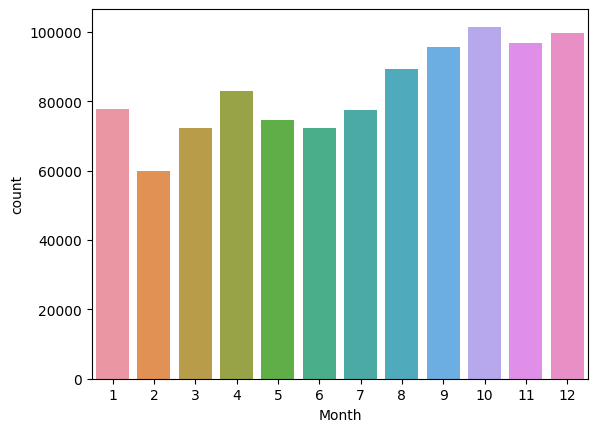

3     0.118420
12    0.094617
10    0.092691
11    0.088729
8     0.087185
9     0.085496
4     0.078113
7     0.075775
1     0.073937
6     0.073036
5     0.071551
2     0.060450
Name: Month, dtype: float64


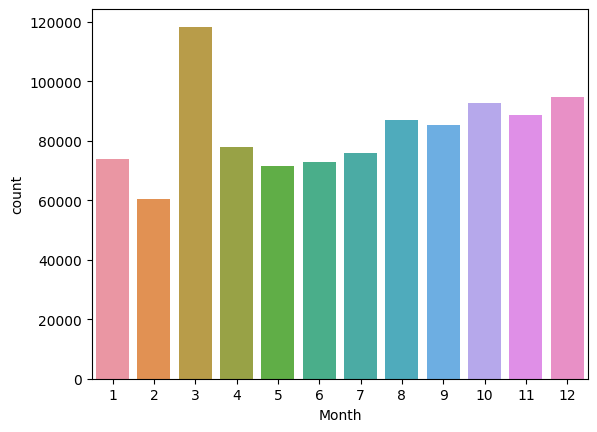

In [ ]:
# Month
print(train['Month'].value_counts()/train.shape[0])
sns.countplot(x = train['Month'])
plt.show()

print(test['Month'].value_counts()/train.shape[0])
sns.countplot(x = test['Month'])
plt.show()

21    0.033719
18    0.033601
19    0.033552
12    0.033475
16    0.033345
26    0.033307
11    0.033150
20    0.033116
10    0.033056
17    0.033053
15    0.033044
9     0.033022
25    0.032999
8     0.032994
14    0.032860
24    0.032786
13    0.032771
27    0.032752
7     0.032625
6     0.032600
23    0.032518
22    0.032441
28    0.032308
5     0.032302
2     0.032300
4     0.032234
1     0.032231
3     0.032052
30    0.031155
29    0.030551
31    0.018081
Name: Day_of_Month, dtype: float64


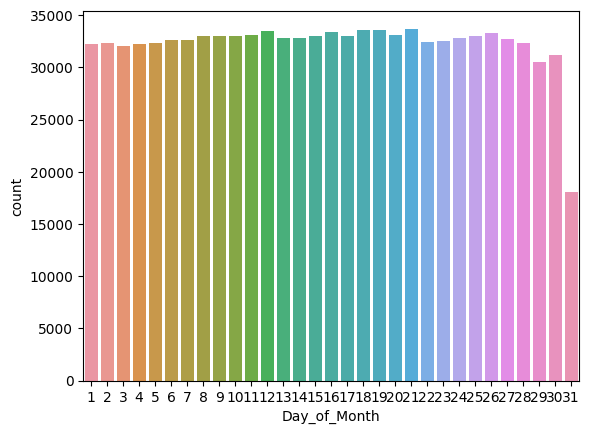

13    0.035512
20    0.035253
19    0.034451
12    0.034339
21    0.034167
15    0.034100
11    0.034020
18    0.033768
8     0.033403
9     0.033359
1     0.033305
16    0.033251
10    0.033235
14    0.033178
2     0.033059
22    0.032983
6     0.032828
17    0.032672
4     0.032529
23    0.032335
7     0.032164
5     0.031910
3     0.031839
26    0.031805
27    0.031291
28    0.031153
25    0.030793
24    0.030766
30    0.030049
29    0.028911
31    0.017572
Name: Day_of_Month, dtype: float64


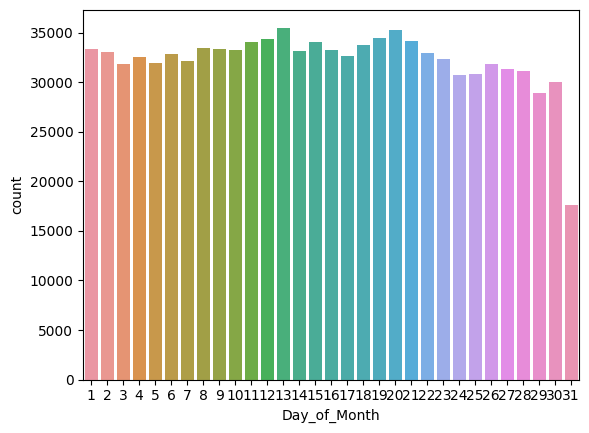

In [ ]:
# Day of Month
print(train['Day_of_Month'].value_counts()/train.shape[0])
sns.countplot(x = train['Day_of_Month'])
plt.show()

print(test['Day_of_Month'].value_counts()/train.shape[0])
sns.countplot(x = test['Day_of_Month'])
plt.show()

In [ ]:
# Cancelled, Diverted
display(train.describe()[['Cancelled']].T)
display(train.describe()[['Diverted']].T)

print('-' * 60)
display(test.describe()[['Cancelled']].T)
display(test.describe()[['Diverted']].T)


,count,mean,std,min,25%,50%,75%,max
Cancelled,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
Diverted,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Cancelled,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
Diverted,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


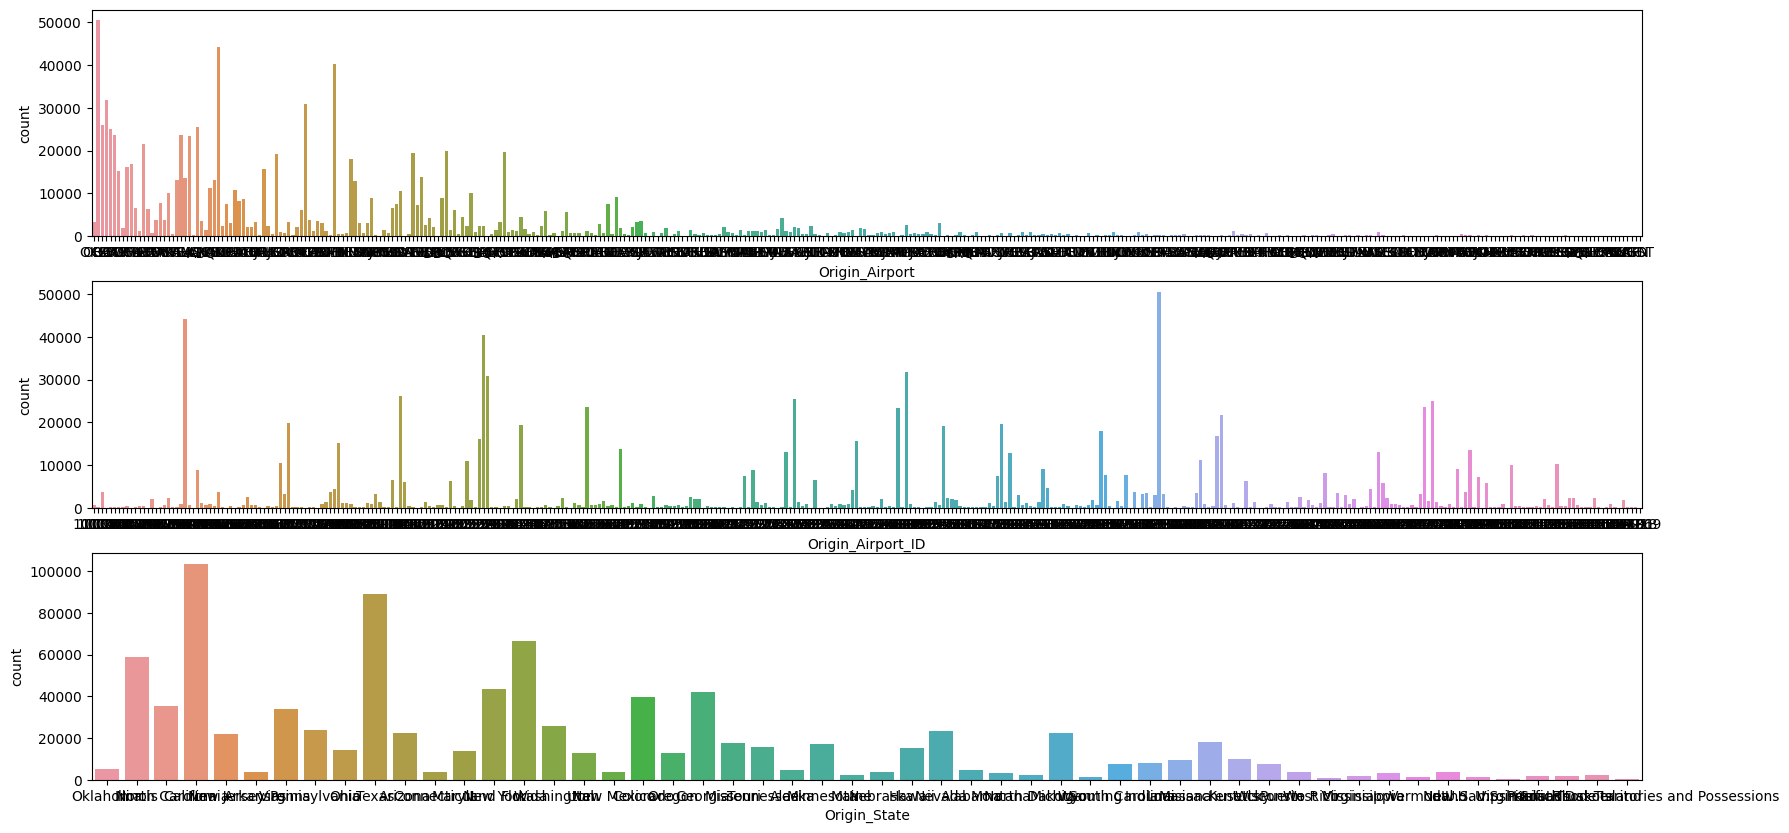

------------------------------------------------------------------------------------------------------------------------------------------------------


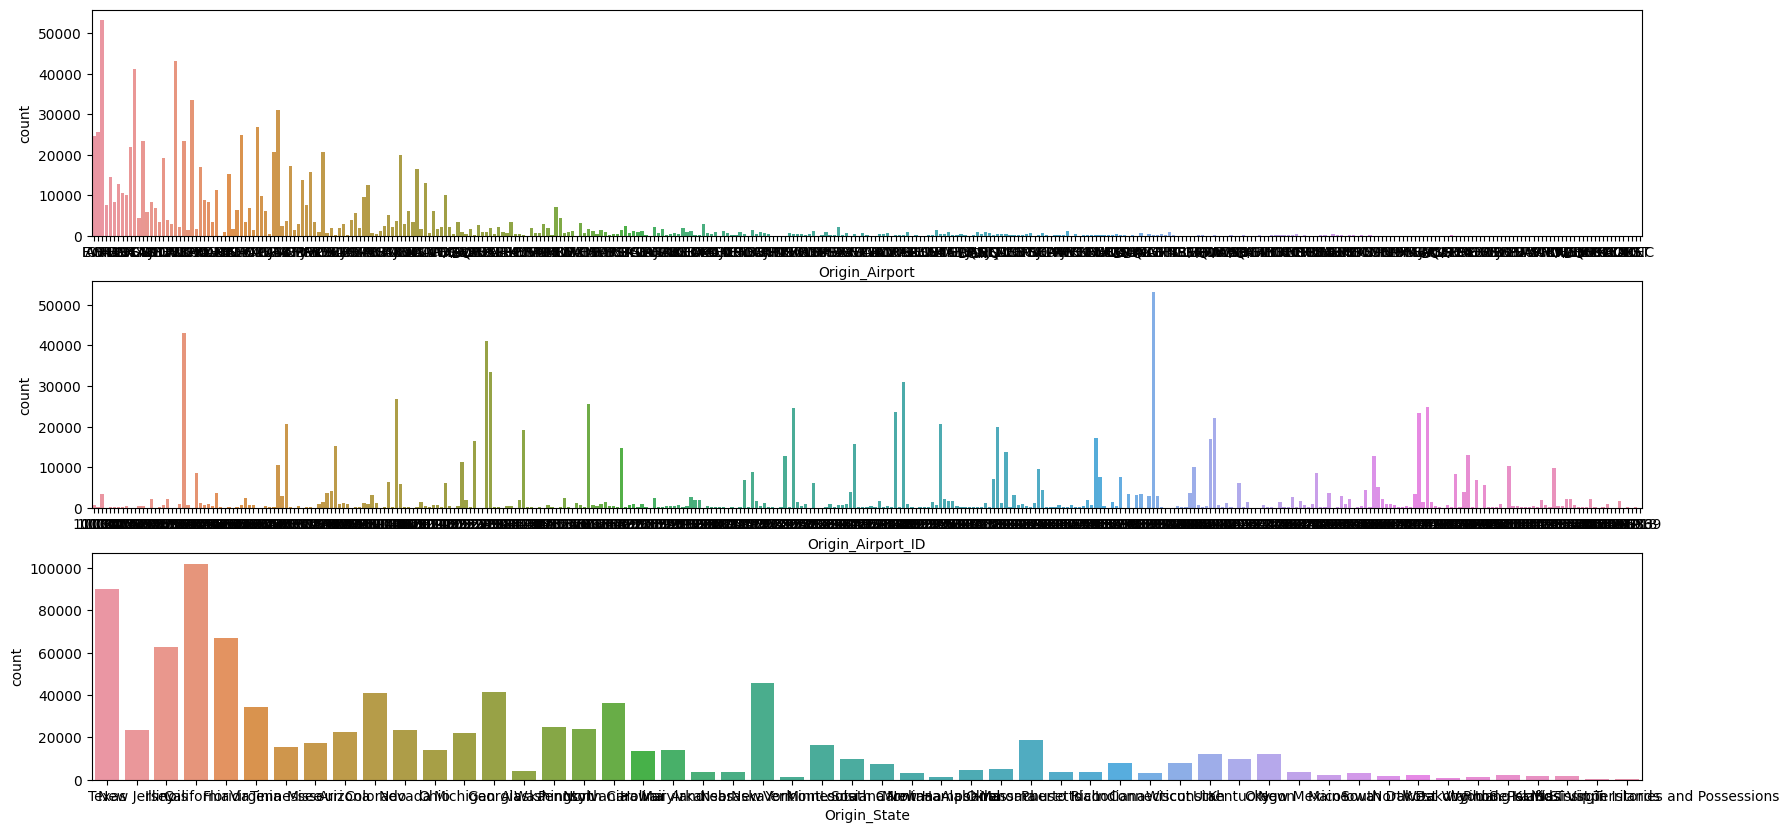

In [ ]:
# Origin_Airport, Origin_Airport_ID, Origin_State
plt.figure(figsize = (20, 10))
plt.subplot(3, 1, 1)
sns.countplot(x = 'Origin_Airport', data = train)

plt.subplot(3, 1, 2)
sns.countplot(x = 'Origin_Airport_ID', data = train)

plt.subplot(3, 1, 3)
sns.countplot(x = 'Origin_State', data = train)
plt.show()

print('-' * 150)
plt.figure(figsize = (20, 10))
plt.subplot(3, 1, 1)
sns.countplot(x = 'Origin_Airport', data = test)

plt.subplot(3, 1, 2)
sns.countplot(x = 'Origin_Airport_ID', data = test)

plt.subplot(3, 1, 3)
sns.countplot(x = 'Origin_State', data = test)
plt.show()

In [ ]:
# Origin_State별 Origin_Airport, Origin_Airport_ID(train)
origin_train = train.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Origin_Airport'], as_index = False)[['ID']].count()


count = 0
for i in origin_train['Origin_Airport_ID'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('train : Origin_Airport_ID는 Origin_State와 1:1 대응이 아니다.')
else :
    print('train : Origin_Airport_ID는 Origin_State와 1:1 대응이다.')


count = 0
for i in origin_train['Origin_Airport'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('train : Origin_Airport는 Origin_State와 1:1 대응이 아니다.')
else :
    print('train : Origin_Airport는 Origin_State와 1:1 대응이다.')


# Origin_State별 Origin_Airport, Origin_Airport_ID(test)
origin_test = test.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Origin_Airport'], as_index = False)[['ID']].count()


count = 0
for i in origin_test['Origin_Airport_ID'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('test : Origin_Airport_ID는 Origin_State와 1:1 대응이 아니다.')
else :
    print('test : Origin_Airport_ID는 Origin_State와 1:1 대응이다.')


count = 0
for i in origin_test['Origin_Airport'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('test : Origin_Airport는 Origin_State와 1:1 대응이 아니다.')
else :
    print('test : Origin_Airport는 Origin_State와 1:1 대응이다.')

train : Origin_Airport_ID는 Origin_State와 1:1 대응이다.
train : Origin_Airport는 Origin_State와 1:1 대응이다.
test : Origin_Airport_ID는 Origin_State와 1:1 대응이다.
test : Origin_Airport는 Origin_State와 1:1 대응이다.


In [ ]:
# Destination_Airport, Destination_Airport_ID, Destination_State (train)
Destination_train = train.groupby(by = ['Destination_State', 'Destination_Airport_ID', 'Destination_Airport'], as_index = False)[['ID']].count()


count = 0
for i in Destination_train['Destination_Airport_ID'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('train: Destination_Airport_ID는 Destination_State와 1:1 대응이 아니다.')
else :
    print('train : Destination_Airport_ID는 Destination_State와 1:1 대응이다.')


count = 0
for i in Destination_train['Destination_Airport'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('train : Destination_Airport는 Destination_State와 1:1 대응이 아니다.')
else :
    print('train : Destination_Airport는 Destination_State와 1:1 대응이다.')


# Destination_Airport, Destination_Airport_ID, Destination_State (test)
Destination_test = test.groupby(by = ['Destination_State', 'Destination_Airport_ID', 'Destination_Airport'], as_index = False)[['ID']].count()


count = 0
for i in Destination_test['Destination_Airport_ID'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('test : Destination_Airport_ID는 Destination_State와 1:1 대응이 아니다.')
else :
    print('test : Destination_Airport_ID는 Destination_State와 1:1 대응이다.')


count = 0
for i in Destination_test['Destination_Airport'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('test : Destination_Airport는 Destination_State와 1:1 대응이 아니다.')
else :
    print('test : Destination_Airport는 Destination_State와 1:1 대응이다.')

train : Destination_Airport_ID는 Destination_State와 1:1 대응이다.
train : Destination_Airport는 Destination_State와 1:1 대응이다.
test : Destination_Airport_ID는 Destination_State와 1:1 대응이다.
test : Destination_Airport는 Destination_State와 1:1 대응이다.


------------------------------------------------------------------------------------------------------------------------------------------------------
train


,count,mean,std,min,25%,50%,75%,max
Distance,1000000.0,784.078499,590.790469,16.0,350.0,623.0,1020.0,5095.0


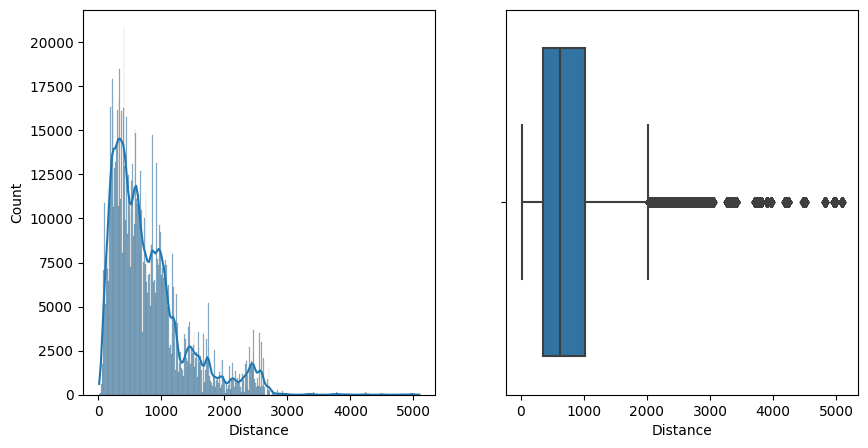

------------------------------------------------------------------------------------------------------------------------------------------------------
test


,count,mean,std,min,25%,50%,75%,max
Distance,1000000.0,795.849058,594.558756,16.0,358.0,634.0,1034.0,5095.0


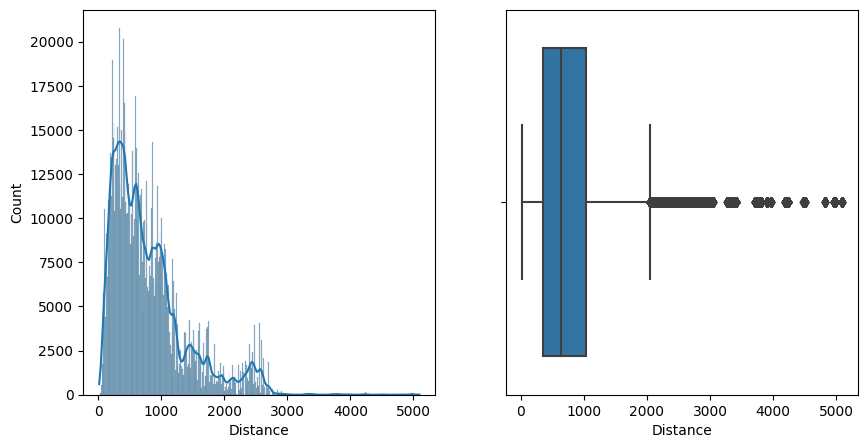

In [ ]:
# Distance

print('-' * 150)
print('train')
display(train.describe()[['Distance']].T)



plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.histplot(x = 'Distance', data = train, kde= True)
plt.subplot(1,2,2)
sns.boxplot(x = 'Distance', data = train)
plt.show()

print('-' * 150)
print('test')
display(test.describe()[['Distance']].T)



plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.histplot(x = 'Distance', data = test, kde= True)
plt.subplot(1,2,2)
sns.boxplot(x = 'Distance', data = test)
plt.show()

Southwest Airlines Co.                       0.182113
Delta Air Lines Inc.                         0.089750
SkyWest Airlines Inc.                        0.086867
United Air Lines Inc.                        0.084070
American Airlines Inc.                       0.082755
JetBlue Airways                              0.041643
Republic Airlines                            0.033582
Alaska Airlines Inc.                         0.029141
Envoy Air                                    0.027455
Spirit Air Lines                             0.024998
Comair Inc.                                  0.024723
Mesa Airlines Inc.                           0.024679
Endeavor Air Inc.                            0.023172
ExpressJet Airlines Inc.                     0.020144
Frontier Airlines Inc.                       0.017415
Allegiant Air                                0.013667
Air Wisconsin Airlines Corp                  0.013400
Horizon Air                                  0.013087
Hawaiian Airlines Inc.      

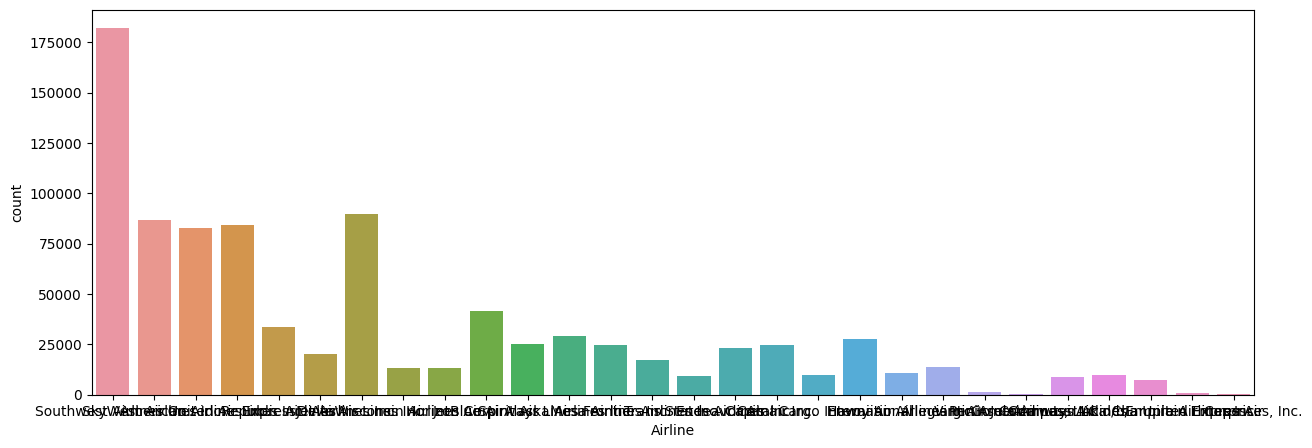

------------------------------------------------------------------------------------------------------------------------------------------------------
Southwest Airlines Co.                       0.183258
Delta Air Lines Inc.                         0.086363
American Airlines Inc.                       0.086056
SkyWest Airlines Inc.                        0.085650
United Air Lines Inc.                        0.083733
JetBlue Airways                              0.044116
Republic Airlines                            0.033184
Alaska Airlines Inc.                         0.028356
Envoy Air                                    0.027977
Comair Inc.                                  0.025198
Spirit Air Lines                             0.024912
Mesa Airlines Inc.                           0.024271
Endeavor Air Inc.                            0.023006
ExpressJet Airlines Inc.                     0.020451
Frontier Airlines Inc.                       0.018920
Allegiant Air                          

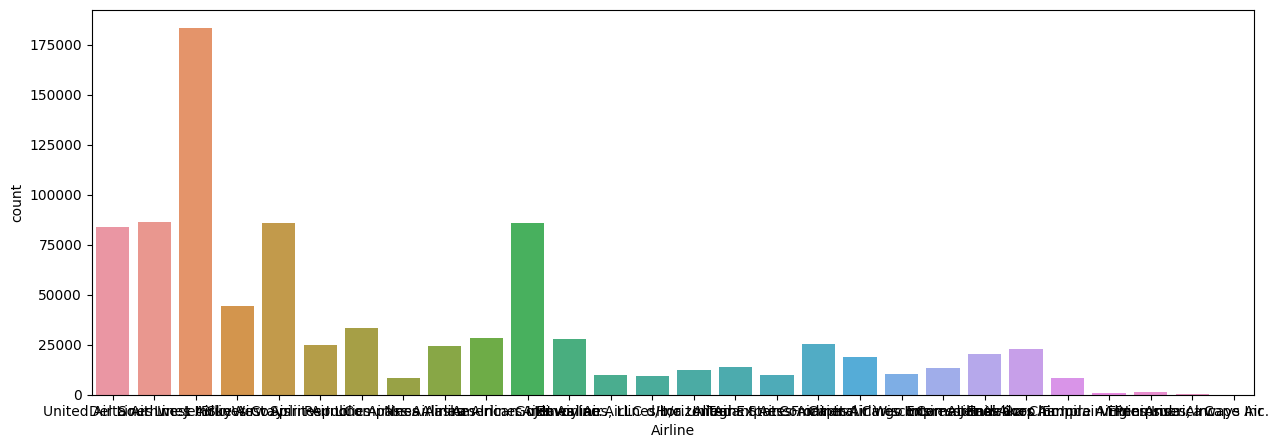

In [ ]:
# Airline
print(train['Airline'].value_counts()/train.shape[0])
plt.figure(figsize=(15,5))
sns.countplot(x = train['Airline'])
plt.show()

print('-' * 150)
print(test['Airline'].value_counts()/test.shape[0])
plt.figure(figsize=(15,5))
sns.countplot(x = test['Airline'])
plt.show()

UA    0.206211
WN    0.182189
AA    0.182099
DL    0.161266
AS    0.048155
B6    0.041477
NK    0.025074
F9    0.017458
G4    0.013746
HA    0.012019
VX    0.001316
Name: Carrier_Code(IATA), dtype: float64


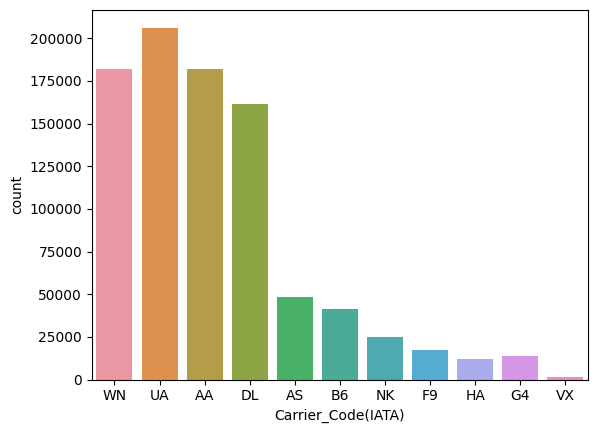

----------------------------------------------------------------------------------------------------
UA    0.200174
AA    0.182635
WN    0.179818
DL    0.152685
AS    0.045966
B6    0.043958
NK    0.025579
F9    0.018982
G4    0.014061
HA    0.010684
OO    0.005111
OH    0.002517
MQ    0.002126
YV    0.001720
YX    0.001650
9E    0.001375
VX    0.001260
EV    0.000706
Name: Carrier_Code(IATA), dtype: float64


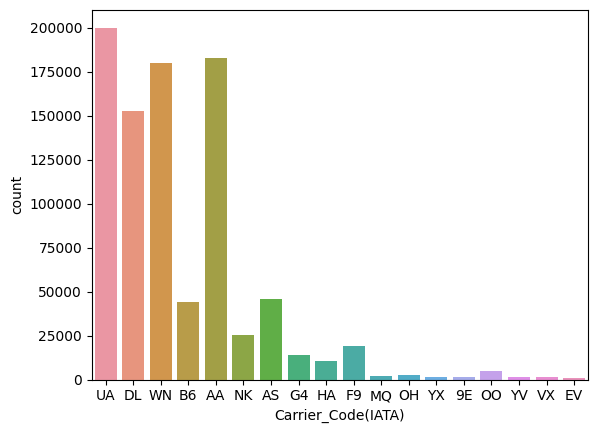

In [ ]:
# Carrier_Code(IATA)
print(train['Carrier_Code(IATA)'].value_counts()/train.shape[0])
sns.countplot(x = train['Carrier_Code(IATA)'])
plt.show()

print('-' * 100)
print(test['Carrier_Code(IATA)'].value_counts()/test.shape[0])
sns.countplot(x = test['Carrier_Code(IATA)'])
plt.show()

19393.0    0.182025
19790.0    0.089958
20304.0    0.086902
19977.0    0.083984
19805.0    0.082860
20409.0    0.041615
20452.0    0.033351
19930.0    0.029085
20398.0    0.027474
20416.0    0.024983
20397.0    0.024838
20378.0    0.024699
20363.0    0.023113
20366.0    0.020197
20436.0    0.017440
20368.0    0.013739
20046.0    0.013319
19687.0    0.013107
19690.0    0.010921
20427.0    0.009962
20500.0    0.009532
20237.0    0.009321
21167.0    0.008813
20445.0    0.007124
21171.0    0.001324
20263.0    0.001052
20225.0    0.000142
20253.0    0.000123
Name: Carrier_ID(DOT), dtype: float64


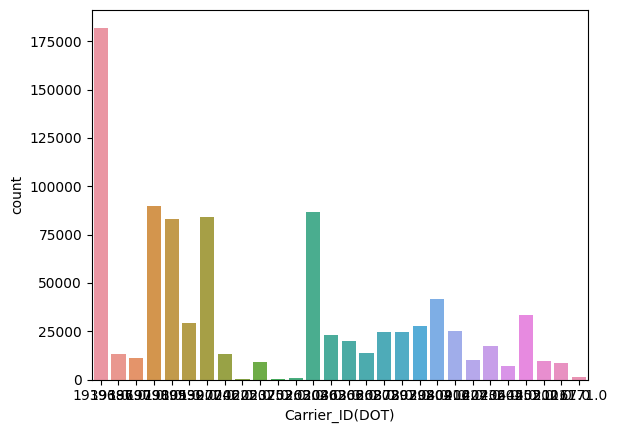

----------------------------------------------------------------------------------------------------
19393.0    0.179910
19805.0    0.087875
19790.0    0.086309
20304.0    0.086241
19977.0    0.082990
20409.0    0.044001
20452.0    0.033114
19930.0    0.028877
20398.0    0.028636
20397.0    0.026435
20416.0    0.025386
20378.0    0.024627
20363.0    0.023133
20366.0    0.020082
20436.0    0.019097
20368.0    0.014014
20046.0    0.012580
19687.0    0.011822
19690.0    0.009620
20427.0    0.009549
20237.0    0.009433
20500.0    0.008904
21167.0    0.008138
20445.0    0.007633
21171.0    0.001278
20263.0    0.001017
20225.0    0.000189
20253.0    0.000104
Name: Carrier_ID(DOT), dtype: float64


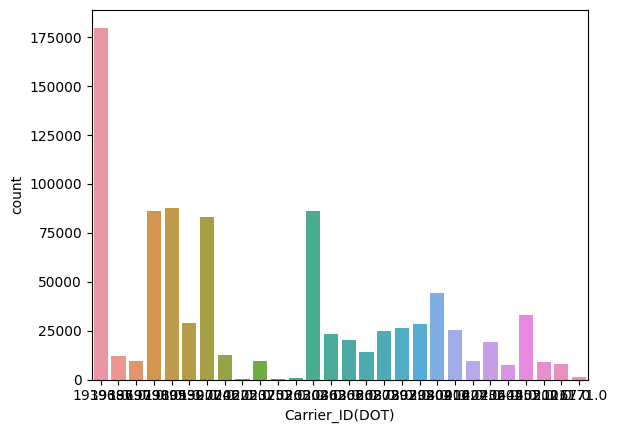

In [ ]:
# Carrier_ID(DOT)
print(train['Carrier_ID(DOT)'].value_counts()/train.shape[0])
sns.countplot(x = train['Carrier_ID(DOT)'])
plt.show()

print('-' * 100)
print(test['Carrier_ID(DOT)'].value_counts()/test.shape[0])
sns.countplot(x = test['Carrier_ID(DOT)'])
plt.show()

In [ ]:
# Tail_Number -> 값이 너무 많아서 문제
# print(train['Tail_Number'].value_counts()/train.shape[0])
# sns.countplot(x = train['Tail_Number'])
# plt.show()

In [ ]:
tail_train = train.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail_train['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('train : Carrier_ID(DOT)는 Airline과 1:1 대응이 아니다.')
else :
    print('train : Carrier_ID(DOT)는 Airline과 1:1 대응이다')


tail_test = test.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail_test['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

if count != 0:
    print('test : Carrier_ID(DOT)는 Airline과 1:1 대응이 아니다.')
else :
    print('test : Carrier_ID(DOT)는 Airline과 1:1 대응이다')

train : Carrier_ID(DOT)는 Airline과 1:1 대응이다
test : Carrier_ID(DOT)는 Airline과 1:1 대응이다


Not_Delayed    0.210001
Delayed        0.045000
Name: Delay, dtype: float64


<Axes: xlabel='Delay', ylabel='count'>

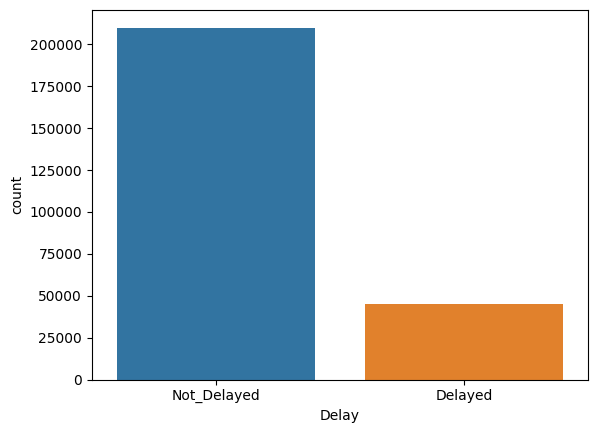

In [ ]:
# Delay -> target 값
print(train['Delay'].value_counts()/train.shape[0])

sns.countplot(x='Delay', data = train)

# Data Pre-Processing

## 결측치

In [ ]:
print(train.isna().sum())
print('-'*50)
print(train.isna().sum()/train.shape[0])

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64
--------------------------------------------------
ID                          0.000000
Month                       0.000000
Day_of_Month                0.000000
Estimated_Departure_Time    0.109019
Estimated_Arrival_Time      0.109040
Cancelled                   0.000000
Diverted                    0.000000
Origin_Airpo

In [ ]:
print(test.isna().sum())
print('-'*50)
print(test.isna().sum()/test.shape[0])

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    108984
Estimated_Arrival_Time      109048
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                106505
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           106523
Distance                         0
Airline                     106527
Carrier_Code(IATA)          108993
Carrier_ID(DOT)             109006
Tail_Number                      0
dtype: int64
--------------------------------------------------
ID                          0.000000
Month                       0.000000
Day_of_Month                0.000000
Estimated_Departure_Time    0.108984
Estimated_Arrival_Time      0.109048
Cancelled                   0.000000
Diverted                    0.000000
Origin_Airport              0.000000
Origin_Air

State 결측치
- Origin은 Origin_Airport와 Airport ID로 결측치 채우기
- Destination은 Destination_Airport와 Airport ID로 결측치 채우기

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
origin_train.head(3)

,Origin_State,Origin_Airport_ID,Origin_Airport,ID
0,Alabama,10562,BFM,5
1,Alabama,10599,BHM,2153
2,Alabama,11308,DHN,136


In [ ]:
origin_test.head(2)

,Origin_State,Origin_Airport_ID,Origin_Airport,ID
0,Alabama,10562,BFM,8
1,Alabama,10599,BHM,2157


- train

In [ ]:
# Origin_Airport_ID가 같은 값으로 Origin_State 채우기
for i in range(len(train)):
    if train['Origin_State'][i] == None:
        count = 0
        for j in range(len(origin_train)):
            if train['Origin_Airport_ID'][i] == origin_train['Origin_Airport_ID'][j] :
                train.loc[i, 'Origin_State'] = origin_train['Origin_State'][j]
                break
            else:
                count += 1
                pass

        if count >= len(origin_train):
            print('결측치를 대체하지 못했습니다.')

print('Done')

Done


- test

In [ ]:
# Origin_Airport_ID가 같은 값으로 Origin_State 채우기()
for i in range(len(test)):
    if test['Origin_State'][i] == None:
        count = 0
        for j in range(len(origin_test)):
            if test['Origin_Airport_ID'][i] == origin_test['Origin_Airport_ID'][j] :
                test.loc[i, 'Origin_State'] = origin_test['Origin_State'][j]
                break
            else:
                count += 1
                pass

        if count >= len(origin_test):
            print('결측치를 대체하지 못했습니다.')

print('Done')

결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
Done


- train

In [ ]:
# Destination_Airport_ID가 같은 값으로 Destination_State 채우기
for i in range(len(train)):
    if train['Destination_State'][i] == None:
        count = 0
        for j in range(len(Destination_train)):
            if train['Destination_Airport_ID'][i] == Destination_train['Destination_Airport_ID'][j] :
                train.loc[i, 'Destination_State'] = Destination_train['Destination_State'][j]
                break
            else:
                count += 1
                pass

        if count >= len(Destination_train):
            print('결측치를 대체하지 못했습니다.')

print('Done')

결측치를 대체하지 못했습니다.
Done


In [ ]:
# 남은 결측치 처리
train.drop(train.loc[(train['Destination_State'].isna())].index, axis = 0, inplace = True)

- test

In [ ]:
# Destination_Airport_ID가 같은 값으로 Destination_State 채우기
for i in range(len(test)):
    if test['Destination_State'][i] == None:
        count = 0
        for j in range(len(Destination_test)):
            if test['Destination_Airport_ID'][i] == Destination_test['Destination_Airport_ID'][j] :
                test.loc[i, 'Destination_State'] = Destination_test['Destination_State'][j]
                break
            else:
                count += 1
                pass

        if count >= len(Destination_test):
            print('결측치를 대체하지 못했습니다.')

print('Done')

결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
결측치를 대체하지 못했습니다.
Done


In [ ]:
# 남은 결측치 처리
test['Origin_State'].fillna(test['Origin_State'].mode()[0], inplace = True)
test['Destination_State'].fillna(test['Destination_State'].mode()[0], inplace = True)

In [ ]:
train.reset_index(inplace = True)
test.reset_index(inplace = True)

Airline, Carrier_ID(DOT) 결측치
- Airline과 Carrier_ID(DOT)는 1:1 대응으로 서로 결측치 대체
- Carrier_ID(DOT)는 제거
- 대체하지 못한 값은 제거

- train

In [ ]:
# Airline의 결측치를 1:1대응으로 채우기

train.loc[train['Airline'].isna(), 'Airline'] = 'isnull'
train.loc[train['Airline']== 'isnull', 'Airline'] = None

for i in range(len(train)):
    if train['Airline'][i] == None:
        count = 0
        for j in range(len(tail_train)):
            if train['Carrier_ID(DOT)'][i] == tail_train['Carrier_ID(DOT)'][j] :
                train.loc[i, 'Airline'] = tail_train['Airline'][j]
                break
            else:
                count += 1
                pass

print('Done')

Done


In [ ]:
train= train.dropna(subset= ['Airline'])

- test

In [ ]:
# Airline의 결측치를 1:1대응으로 채우기

test.loc[test['Airline'].isna(), 'Airline'] = 'isnull'
test.loc[test['Airline']== 'isnull', 'Airline'] = None

for i in range(len(test)):
    if test['Airline'][i] == None:
        count = 0
        for j in range(len(tail_test)):
            if test['Carrier_ID(DOT)'][i] == tail_test['Carrier_ID(DOT)'][j] :
                test.loc[i, 'Airline'] = tail_test['Airline'][j]
                break
            else:
                count += 1
                pass

print('Done')

Done


In [ ]:
test.loc[test['Airline'].isna(), 'Airline'] = test['Airline'].mode()[0]
test.loc[test['Carrier_ID(DOT)'].isna(), 'Carrier_ID(DOT)'] = test['Carrier_ID(DOT)'].mode()[0]

Estimated_Departure_Time 결측치
- 출발 시간과 도착 시간이 둘다 결측치 인 것은 10000개로 줄엄듬
- 둘 중 하나만 결측치를 가지는 경우에는 머신러닝 학습으로 에측
- 둘다 결측치를 가지는 경우에는 K-means를 사용하여 결측치 채우기

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=100)
train['Estimated_Departure_Time'] = imputer.fit_transform(train.loc[:, ['Estimated_Departure_Time']])
test['Estimated_Departure_Time'] = imputer.fit_transform(test.loc[:,['Estimated_Departure_Time']])
train['Estimated_Arrival_Time'] = imputer.fit_transform(train.loc[:,['Estimated_Arrival_Time']])
test['Estimated_Arrival_Time'] = imputer.fit_transform(test.loc[:,['Estimated_Arrival_Time']])

In [ ]:
import joblib
joblib.dump(train, '/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/SEN/train_sen.pkl')
joblib.dump(test, '/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/SEN/test_sen.pkl')

In [ ]:
import joblib
train = joblib.load('/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/SEN/train_sen.pkl')
test = joblib.load('/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/SEN/test_sen.pkl')

In [ ]:
# train.drop(train.loc[(train['Estimated_Departure_Time'].isna())&(train['Estimated_Arrival_Time'].isna())].index, axis = 0, inplace = True)
train = train.reset_index(False)
train.drop('level_0', axis = 1, inplace = True)

In [ ]:
train['Total_Time'] = None
for i in range(len(train)):
    if train['Estimated_Departure_Time'][i] > train['Estimated_Arrival_Time'][i] :
        train.loc[i, 'Total_Time'] = 2400-(train['Estimated_Arrival_Time'][i] - train['Estimated_Departure_Time'][i])
    else :
        train.loc[i, 'Total_Time'] = train['Estimated_Arrival_Time'][i] - train['Estimated_Departure_Time'][i]

test['Total_Time'] = None
for i in range(len(test)):
    if test['Estimated_Departure_Time'][i] > test['Estimated_Arrival_Time'][i] :
        test.loc[i, 'Total_Time'] = 2400-(test['Estimated_Arrival_Time'][i] - test['Estimated_Departure_Time'][i])
    else :
        test.loc[i, 'Total_Time'] = test['Estimated_Arrival_Time'][i] - test['Estimated_Departure_Time'][i]

In [ ]:
train['Total_Time'].isna().sum()

In [ ]:
test['Total_Time'].isna().sum()

파생변수 생성

In [ ]:
df_train['dep_hour'] = df_train['Estimated_Departure_Time'].astype('string').str[:-2]
df_train['arr_hour'] = df_train['Estimated_Arrival_Time'].astype('string').str[:-2]

df_test['dep_hour'] = df_test['Estimated_Departure_Time'].astype('string').str[:-2]
df_test['arr_hour'] = df_test['Estimated_Arrival_Time'].astype('string').str[:-2]

## 이상치

- Estimated_Departure_Time
- Estimated_Arrival_Time

    * 머신러닝 학습으로 나온 Total_Time으로 결측치 채울 수 있음
    * Test에도 적용을 해야함
    * 하지만 출발 시간과 같은 좋은 변수를 사용할 수 없게 됨

In [ ]:
plt.figure(figsize = (20, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x = 'Distance', data = df_train)
plt.subplot(2, 2, 2)
sns.histplot(x = 'Distance', data = df_train, kde = True)

plt.subplot(2, 2, 3)
sns.boxplot(x = 'Distance', data = df_test)
plt.subplot(2, 2, 4)
sns.histplot(x = 'Distance', data = df_test, kde = True)
plt.show()

In [ ]:
plt.figure(figsize = (20, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x = 'Total_Time', data = df_train)
plt.subplot(2, 2, 2)
sns.histplot(x = 'Total_Time', data = df_train, kde = True)

plt.subplot(2, 2, 3)
sns.boxplot(x = 'Total_Time', data = df_test)
plt.subplot(2, 2, 4)
sns.histplot(x = 'Total_Time', data = df_test, kde = True)
plt.show()

In [ ]:
df_train['Distance'] = np.log1p(df_train['Distance'])
df_test['Distance'] = np.log1p(df_test['Distance'])
df_train['Total_Time'] = np.log1p(df_train['Total_Time'])
df_test['Total_Time'] = np.log1p(df_test['Total_Time'])

In [ ]:
plt.figure(figsize = (20, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x = 'Distance', data = df_train)
plt.subplot(2, 2, 2)
sns.histplot(x = 'Distance', data = df_train, kde = True)

plt.subplot(2, 2, 3)
sns.boxplot(x = 'Distance', data = df_test)
plt.subplot(2, 2, 4)
sns.histplot(x = 'Distance', data = df_test, kde = True)
plt.show()

In [ ]:
plt.figure(figsize = (20, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x = 'Total_Time', data = df_train)
plt.subplot(2, 2, 2)
sns.histplot(x = 'Total_Time', data = df_train, kde = True)

plt.subplot(2, 2, 3)
sns.boxplot(x = 'Total_Time', data = df_test)
plt.subplot(2, 2, 4)
sns.histplot(x = 'Total_Time', data = df_test, kde = True)
plt.show()

사용할 변수 추출

In [ ]:
train.info()

In [ ]:
df_train = df_train.loc[:,['Month', 'Origin_State','Origin_Airport', 'Destination_State','Destination_Airport', 'Distance', 'Airline', 'Total_Time',  'dep_hour', 'arr_hour', 'Tail_Number', 'Delay'] ]

In [ ]:
test.info()

In [ ]:
df_test = df_test.loc[:,['Month', 'Origin_State','Origin_Airport', 'Destination_State','Destination_Airport', 'Distance', 'Airline', 'Total_Time',  'dep_hour', 'arr_hour', 'Tail_Number', 'Delay'] ]

# 스케일링

In [ ]:
# # 특징 해싱
cols = ['Month', 'Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'dep_hour', 'arr_hour', 'Tail_Number']

from sklearn.feature_extraction import FeatureHasher
FHdf_train = pd.DataFrame(None)
for col in cols:
  fh = FeatureHasher(n_features = 10, input_type = 'string')
  hash_df = fh.transform(df_train[[col]].astype(str).values)
  hash_df = pd.DataFrame(hash_df.todense(), columns = [f'{col}_{i}' for i in range(10)])
  FHdf_train = pd.concat([FHdf_train, hash_df], axis = 1)


cols = ['Month', 'Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'dep_hour', 'arr_hour', 'Tail_Number']

from sklearn.feature_extraction import FeatureHasher
FHdf_test = pd.DataFrame(None)
for col in cols:
  fh = FeatureHasher(n_features = 10, input_type = 'string')
  hash_df = fh.transform(df_test[[col]].astype(str).values)
  hash_df = pd.DataFrame(hash_df.todense(), columns = [f'{col}_{i}' for i in range(10)])
  FHdf_test = pd.concat([FHdf_test, hash_df], axis = 1)

In [ ]:
# 스케일링

# train
df_train['Distance'] = (df_train['Distance'] - df_train['Distance'].min()) / (df_train['Distance'].max() - df_train['Distance'].min())
df_train['Total_Time'] = (df_train['Total_Time'] - df_train['Total_Time'].min()) / (df_train['Total_Time'].max() - df_train['Total_Time'].min())


# test
df_test['Distance'] = (df_test['Distance'] - df_test['Distance'].min()) / (df_test['Distance'].max() - df_test['Distance'].min())
df_test['Total_Time'] = (df_test['Total_Time'] - df_test['Total_Time'].min()) / (df_test['Total_Time'].max() - df_test['Total_Time'].min())

In [ ]:
x_train = pd.concat([FHdf_train, x_train], axis = 1)
x_test = pd.concat([FHdf_test, x_test], axis = 1)

# Y 비지도 학습

In [ ]:
X = df_train.loc[df_train['Delay'].astype(str)!='None'].drop('Delay', axis = 1)
X_nan = df_train.loc[df_train['Delay'].astype(str)=='None'].drop('Dleay', axis = 1)
y = df_trian[df_train['Delay'].astype(str)!='None']['Delay']

stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    verbose = True
)

stclf.fit(X, y)


# 결측치 예측
X_nan['Delay_pred'] = stclf.predict(X_nan[original_col])
df_train.loc[df_train['Delay'].astype(str) == 'None', 'Delay'] = X_nan['Delay_pred']

/usr/local/lib/python3.9/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Tail_Number,Delay,Total_Time


In [ ]:
df_train.loc[df_train['Delay'] == 'Not_Delayed', 'Delay'] = 0
df_train.loc[df_train['Delay'] == 'Delayed', 'Delay'] = 1

In [ ]:
df_train['Delay'] = df_train['Delay'].astype('int64')

In [ ]:
import joblib
joblib.dump(df_train, '/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/df_train_sen.pkl')
joblib.dump(df_test, '/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/df_test_sen.pkl')

['/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/df_test_sen.pkl']

In [ ]:
import joblib
df_train = joblib.load('/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/df_train_sen.pkl')
df_test = joblib.load('/content/drive/MyDrive/공모전/항공편 지연 예측 AI 경진대회/df_test_sen.pkl')

# X, y 분리

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976566 entries, 0 to 976565
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        976566 non-null  object 
 1   Month                     976566 non-null  int64  
 2   Day_of_Month              976566 non-null  int64  
 3   Estimated_Departure_Time  880390 non-null  float64
 4   Estimated_Arrival_Time    880327 non-null  float64
 5   Origin_Airport            976566 non-null  int64  
 6   Origin_State              976566 non-null  int64  
 7   Destination_Airport       976566 non-null  int64  
 8   Destination_State         976566 non-null  int64  
 9   Distance                  976566 non-null  float64
 10  Airline                   976566 non-null  int64  
 11  Tail_Number               976566 non-null  int64  
 12  Delay                     976566 non-null  int64  
 13  Total_Time                976566 non-null  f

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  891016 non-null   float64
 4   Estimated_Arrival_Time    890952 non-null   float64
 5   Origin_Airport            1000000 non-null  int64  
 6   Origin_State              1000000 non-null  int64  
 7   Destination_Airport       1000000 non-null  int64  
 8   Destination_State         1000000 non-null  int64  
 9   Distance                  1000000 non-null  float64
 10  Airline                   1000000 non-null  int64  
 11  Tail_Number               1000000 non-null  int64  
 12  Total_Time                1000000 non-null  float64
dtypes: float64(4), int64(8), obj

In [ ]:
x_train = df_train.loc[:,['Month', 'Origin_State','Origin_Airport', 'Destination_State','Destination_Airport', 'Distance', 'Airline', 'Total_Time',  'dep_hour', 'arr_hour', 'Tail_Number'] ]
y_train = df_train.loc[:, 'Delay']

x_test = df_test.loc[:, ['Month',  'Origin_State','Origin_Airport', 'Destination_State','Destination_Airport', 'Distance', 'Airline', 'Total_Time',  'dep_hour', 'arr_hour', 'Tail_Number']]

## 불균형 데이터

In [ ]:
y_train.value_counts()

0    874955
1    101611
Name: Delay, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)


print('전 : ', np.bincount(y_train))
print('후 : ', np.bincount(s_y_train))

전 :  [874955 101611]
후 :  [874955 874955]


# Classification Model Fit

In [ ]:
clf =LogisticRegression(C = 5,  solver = 'sag', penalty = 'l2')
parameters = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty' : ['None', 'l1', 'l2', 'elasticnet'],
    'C' : range(0, 10)
}

grid = GridSearchCV(clf,
                       param_grid = parameters, cv=5)
clf.fit(s_x_train,s_y_train)
# result = pd.DataFrame(grid.cv_results_['params'])
# result['mean_test_score'] = grid.cv_results_['mean_test_score']
# result.sort_values(by='mean_test_score',ascending=False)

RandomForestClassifier()

# Inference

In [ ]:
y_pred = clf.predict_proba(x_test)

#Submit

In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
submission.to_csv('./submission.csv', index=True)

In [ ]:
submission.head(3)

0    723582
1    276418
Name: y_pred, dtype: int64

In [ ]:
submission